# Import Packages and Read Data

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
# kNN Scikit-learn imports
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap

In [3]:
ambulance_csv = '../raw_dispatch_merged_with_comments.csv'

dtypes = {
    'Master_Incident_Number': 'str',
    'Response_Date': 'str',
    'Call_Category': 'str',
    'Time_PhonePickUp': 'str',
    'Nature/Problem': 'str',
    'Division': 'str',
    'Determinant/Medical Code': 'str',
    'Latitude_Decimal': 'float',
    'Longitude_Decimal': 'float',
    'MethodOfCallRcvd': 'str',
    'Call_Back_Phone': 'str',
    'Caller_Type': 'str',
    'Caller_Name': 'str',
    'Caller_Location_Name': 'str',
    'Dispatch Comment': 'str',
    'Response_Number': 'str',
    'Unit ID': 'str',
    'Time_Assigned': 'str',
    'Time_Enroute': 'str',
    'Time_Staged': 'str',
    'Time_ArrivedAtScene': 'str',
    'Transport_Mode': 'str',
    'Time_Depart_Scene': 'str',
    'Time_Arrive_Destination': 'str',
    'Time_Call_Cleared': 'str',
    'Turnout Time': 'str',
    'Drive Time': 'str',
    'Unit Response Time': 'str',
    'Total Response Time': 'str',
    'Scene Time': 'str',
    'Transport Time': 'str',
}

parse_dates = ['Response_Date', 'Time_PhonePickUp', 'Time_Assigned', 'Time_Enroute', 'Time_Staged', \
               'Time_ArrivedAtScene', 'Time_Depart_Scene', 'Time_Arrive_Destination', 'Time_Call_Cleared', \
               'Turnout Time', 'Drive Time', 'Unit Response Time', 'Total Response Time', 'Scene Time', \
               'Transport Time']

In [4]:
data_dispatch = pd.read_csv(ambulance_csv, dtype=dtypes, parse_dates=parse_dates)

# Identidy Fire Districts by $k$-NN

In [5]:
old_zone = data_dispatch[data_dispatch['Response_Date'].dt.date < pd.Timestamp(2015,10,1).date()]
new_zone = data_dispatch[data_dispatch['Response_Date'].dt.date >= pd.Timestamp(2015,10,1).date()]

In [6]:
old_geoloc_set = set(zip(old_zone['Latitude_Decimal'],old_zone['Longitude_Decimal']))
new_geoloc_set = set(zip(new_zone['Latitude_Decimal'],new_zone['Longitude_Decimal']))

In [7]:
print(len(new_zone[new_zone['Latitude_Decimal'] > 0]),len(old_zone[old_zone['Latitude_Decimal'] > 0]))

344224 110054


In [8]:
new_zone = new_zone[new_zone['Latitude_Decimal'] > 0]

In [9]:
# Setup Training and Test data for Scikit-learn
X = new_zone[['Latitude_Decimal','Longitude_Decimal']]
labels, uniques = pd.factorize(new_zone['Division'], sort=True)
neigh = KNeighborsClassifier(n_neighbors=3, weights='distance')
neigh.fit(X, labels)
labels, uniques = pd.factorize(new_zone['Division'], sort=True)
division_new = neigh.predict(old_zone[['Latitude_Decimal','Longitude_Decimal']])
neigh = KNeighborsRegressor(n_neighbors=3, weights = 'distance')
neigh.fit(X, labels)
division_new_reg = neigh.predict(old_zone[['Latitude_Decimal','Longitude_Decimal']])

Text(0.5,1,"3-Class classification (k = 3, weights = 'distance')")

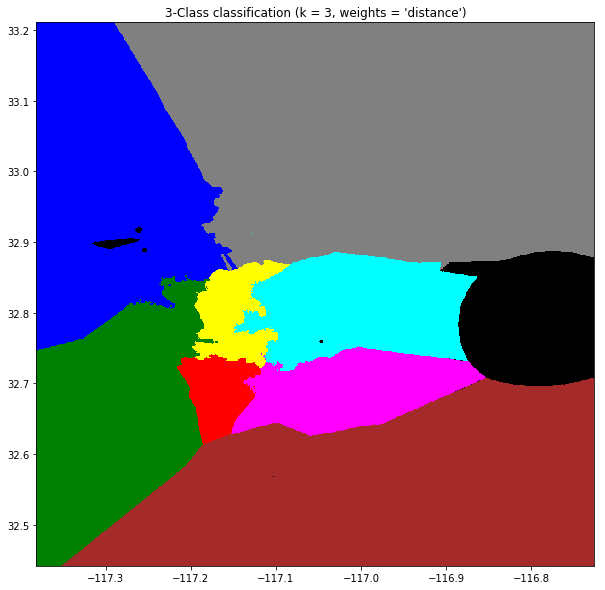

In [10]:
# Decision boundary drawing
n_neighbors = 3
weights = 'distance'
y = labels
h = .001  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['black', 'red', 'yellow', 'green', 'cyan', 'blue', 'magenta', 'grey', 'brown'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf.fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X.values[:, 0].min() - 0.1, X.values[:, 0].max() + 0.1
y_min, y_max = X.values[:, 1].min() - 0.1, X.values[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 10))
plt.pcolormesh(yy, xx, Z, cmap=cmap_light)

# Plot also the training points
# plt.scatter(X.values[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.ylim(xx.min(), xx.max())
plt.xlim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights))

In [11]:
new_labels, uniques = pd.factorize(data_dispatch[data_dispatch['Response_Date'].dt.date >= pd.Timestamp(2015,10,1).date()]['Division'], sort=True)
uniques

Index(['Chula Vista', 'Coronado', 'County', 'Del Mar', 'Imperial Beach',
       'La Mesa', 'Lemon Grove', 'Rancho Santa Fe', 'San Miguel',
       'Solana Beach', 'Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5',
       'Zone 6', 'Zone 7', 'Zone 8'],
      dtype='object')

In [12]:
# label for 'Zone 1' was 10 above, set it to 0 and everything before 'Zone 1' as -1
new_labels = [max(i-10, -1) for i in new_labels]

In [13]:
data_dispatch['New_Zone'] = np.append(division_new, new_labels)
other_zones = ['Chula Vista', 'Coronado', 'County', 'Del Mar', 'Imperial Beach', 'La Mesa', 'Lemon Grove', 
               'National City', 'Poway', 'Rancho Santa Fe', 'San Miguel', 'San Pasqual', 'Solana Beach']
data_dispatch.loc[data_dispatch['Division'].isin(other_zones), 'New_Zone'] = -1

In [14]:
# Summary of the Zone mappings 'Zone 1'~'Zone 8' = 0~7, -1 for others
data_dispatch[['New_Zone','Division']].groupby(['New_Zone','Division']).size()

New_Zone  Division       
-1        Chula Vista            5
          Coronado               1
          County               151
          Del Mar                1
          Imperial Beach         2
          La Mesa               26
          Lemon Grove           17
          National City          1
          Poway                  1
          Rancho Santa Fe        6
          San Miguel             1
          San Pasqual            4
          Solana Beach           1
          Zone 3                 3
          Zone 4                 2
 0        Zone 1             72719
          Zone 2             21751
          Zone 3                 5
 1        Zone 2             62507
          Zone 3              5005
          Zone 4              6909
 2        Zone 2              6884
          Zone 3             40872
          Zone 4              6714
 3        Zone 2                 3
          Zone 3             14474
          Zone 4             56392
 4        Zone 4             

# Identify Types of Dispatch

In [15]:
# Ambulance Canceled (0): 'Unit Response Time' is empty
# Clear-at-Scene (1): 'Time_Arrive_Destination' is empty
# Transport (2): all timestamps are available
data_dispatch['Mission_Type'] = [0 for i in range(len(data_dispatch))]
data_dispatch.loc[data_dispatch['Unit Response Time'].notnull() & data_dispatch['Time_Arrive_Destination'].isnull(), 'Mission_Type'] = 1
data_dispatch.loc[data_dispatch['Time_Arrive_Destination'].notnull(), 'Mission_Type'] = 2

In [16]:
print('No. Transported incidents:', len(data_dispatch[data_dispatch['Mission_Type'] == 0]))

No. Transported incidents: 80687


In [17]:
print('No. Transported incidents:', len(data_dispatch[data_dispatch['Mission_Type'] == 1]))

No. Transported incidents: 91582


In [18]:
print('No. Transported incidents:', len(data_dispatch[data_dispatch['Mission_Type'] == 2]))

No. Transported incidents: 282325


# Write to File

In [19]:
# Extract the required information to a new data frame
data_zones = data_dispatch[['Master_Incident_Number', 'New_Zone', 'Mission_Type', 'Response_Date']].copy()

In [20]:
data_zones.to_csv("incident_newzone.csv", index=False, float_format='%.6f')